<center><h1>MNIST Hand-Written Digit Recognition</h1></center>

### Overview

This notebook uses the k-Nearest Neighbors algorithm to classify hand-written digits from the *MNIST* dataset. The algorithm is implemented from scratch using vanilla Python. The hyperparameters of the model (k, test-train split ratio) are then tuned to increase the accuracy of the model.

### Background

The *MNIST* dataset is a large collection of handwritten digit images (and their corresponding labels), which have been preprocessed for the purposes of machine learning. This notebook uses the *MNIST* dataset with the **k-Nearest Neighbors** (kNN) algorithm, a supervised learning method, to build a simple hand-writing recognition scripts for the digits 0 to 9. The kNN method was chosen since it has a simple algorithm that lends itself well to classification problems. The drawback to this algorithm is that it slows as the size of the dataset grows, and so for larger datasets it does not scale as well as other algorithms.

The Sci-Kit Learn module has an implementation of this algorithm called the KNeighborsClassifier, but for the purposes of this notebook, the algorithm has been implemented from scratch using vanilla Python. Other libraries have been used to present visualisations of how the underlying theory works.


### Definitions

**Classification problem** - returning a discrete value (label) from data based on its properties e.g. predicting colour, category

**k-Nearest Neighbors** - a supervised learning algorithm, commonly used for classification and regression problems

**Regression Problem** - returning a continuous value from data based on its properties e.g predicting height or weight

**Supervised machine learning** - using labelled data to identify the information being presented e.g classifying hand-written digits

**Unsupervised machine learning** - clustering data based solely on its properties, without labelling e.g clustering (such as k-means)

### Contents

Section 1 - Reading the Data

Section 2 - Building the kNN Classifier

Section 3 - Model Testing and Accuracy

Section 4 - Tuning the Hyperparameters

Section 5 - Using Custom Images

Section 6 - References

<center><h2>Section 1 - Reading the Data</h2></center>

### 1.1 - Import Libraries

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import PIL
from sklearn import datasets

### 1.2 - Load the MNIST Dataset

The dataset [1] can be loaded using the ```load_digits``` function from the Sci-Kit Learn library [2]. This returns a dictionary-like object called a Bunch, which has 7 keys- these can be seen in full below. The most useful of these here are ```data``` and ```target```, which refer to the image data and corresponding labels respectively. More information about the dataset and its structure can be found using the ```mnist.DESCR``` method.

In [2]:
# Load the MNIST dataset from Sci-Kit Learn
digits = datasets.load_digits()

print(type(digits))

for key in digits:
    print(key)

<class 'sklearn.utils.Bunch'>
data
target
frame
feature_names
target_names
images
DESCR


### 1.3 - Structure of the Dataset

The dataset contains 1797 64x1 NumPy arrays, each representing a grid of 8x8 pixels. The value in each element corresponds to the brightness of a pixel, and is a float ranging from 0. (black), to 16. (white), with varying shades of grey in between. 

In [3]:
# Extract the image arrays and labels
images = digits.data
labels = digits.target

# Print the first array and its corresponding label
print(f'Image Type: {type(images[0])}')
print(f'Element type: {type(images[0][0])}', end='\n\n')
print(images[0],end='\n\n')
print(f'Label: {labels[0]}')

Image Type: <class 'numpy.ndarray'>
Element type: <class 'numpy.float64'>

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]

Label: 0


### 1.4 - Display the Image

The Matplotlib library's ```imshow``` method can be  used to plot images based on pixel data. Here the first array has been plotted, with the ```cm.gray_r``` colour map. This inverts the colours, so that dark pixels are shown light and vice-versa. This gives an image we are more used to seeing: a white background with black text.

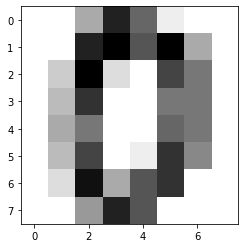

In [4]:
# Convert the data to and grid of 8x8 (could also load in the data pre-formatted using datasets.load-digits().images)
def plot_digit(digit):
    im = [digit[index:index+8] for index in range(0,len(digit),8)]
    plt.imshow(im,cmap=plt.cm.gray_r)

plot_digit(images[0])

### 1.5 - Combine the Images and Labels

The ```load_digits``` function returns ```images``` and ```labels``` separately, but it would be useful to join these together in a series of tuples, so that each image and label are stored next to each other. To do this, we can use the built-in ```zip``` function in Python.

In [5]:
data = list(zip(images,labels))
print(data[0])

(array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.]), 0)


<center><h2>Section 2 - Building the kNN Classifier</h2></center>

### 2.1 - Representing data as points in space

The k-Nearest Neighbor method [3] is a useful tool for classification problems. Each data point in a set of data can store several pieces of information. In this example, each array stores 64 values, which represent the brightness value of pixels for each pixel in an 8x8 image. The number of values stored can be thought of as the number of dimensions a data point has. 

Thinking about this graphically, a data point with 2 values can be plot in 2-dimensional space. This idea can be taken further to 3-dimensional space for 3 values, and n-dimensional sapce for n values.

Below is an example in 2D, where some data has been plot representing items of one class in orange, and a different class in green. These form clusters since we assume items of the same class have similar properties.

If a point with an unknown class is introduced to the plot, can we determine which class it belongs to? kNN uses the distance to a number of neighboring points to determine the most likely class. You can specify the value of neighbouring points, which generically is called *k*.

To do this, you can find the distance between the new point and every other point on the graph, and sort them in descending order. The modal label in the first *k* results is used to classify the unknown point.

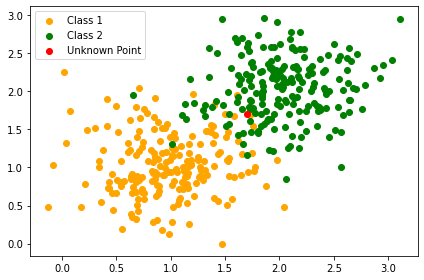

In [6]:
# Generate 400 random data points, separated into two clusters
num_samples = 400
coords, labels = datasets.make_blobs(n_samples = num_samples, centers = [(1,1),(2,2)], cluster_std = 0.4)

# Extract the coordinates
orange = [coord for index, coord in enumerate(coords) if labels[index] == 0]
green = [coord for index, coord in enumerate(coords) if labels[index] == 1]

orange = np.asarray(orange)
green = np.asarray(green)


# Plot the scatter graph
plt.scatter(orange.T[0],orange.T[1],color='orange', label='Class 1')
plt.scatter(green.T[0],green.T[1],color='green', label='Class 2')
plt.scatter(1.7,1.7,color='red', label='Unknown Point')
plt.legend()
plt.tight_layout()
plt.show()

### 2.2 - Euclidean Distance

The straight-line distance between two points in space is called the Euclidean distance, and for 2-dimensional space can be found using the Pythagorean theorem:

&nbsp;  
$$
d(a,b) = \sqrt{(a_1-b_1)^2 + (a_2-b_2)^2}
$$
&nbsp;  
&nbsp;  
&nbsp;   
This can be extended to n-dimensional space, where the euclidean distance between 2 points $a = (a_1,a_2,...,a_n)$ and $b = (b_1,b_2,...,b_n)$ is given by

&nbsp;  
$$
d(a,b) = \sqrt{(a_1-b_1)^2 + (a_2-b_2)^2 + ... + (a_n-b_n)^2}
$$

In [7]:
def euclidean(a,b):
    return sum([(pair[0]-pair[1])**2 for pair in zip(a,b)])**0.5

The Euclidean function defined above should find the Euclidean distance between any two vectors, given they have the same length. To test it works, here are a few vectors of different lengths. 

In [8]:
# Test in 2D
point_1 = [10,5]
point_2 = [20,10]

print(f'Distance between {point_1} and {point_2}: {euclidean(point_1,point_2):.2f}')

# Test in 3D
point_3 = [10,5,1]
point_4 = [20,10,5]

print(f'Distance between {point_3} and {point_4}: {euclidean(point_1,point_2):.2f}')

# Test in 4D
point_1 = [10,5,1,20]
point_2 = [20,10,5,1]

print(f'Distance between {point_1} and {point_2}: {euclidean(point_1,point_2):.2f}')

Distance between [10, 5] and [20, 10]: 11.18
Distance between [10, 5, 1] and [20, 10, 5]: 11.18
Distance between [10, 5, 1, 20] and [20, 10, 5, 1]: 22.41


### 2.3 - Calculate and Sort the Distances

For the next step, a function is needed to apply the Euclidean distance function between the new unknown point, and every known point in the dataset. The distance and the label of the known point should be stored together in a tuple. The entire list can then be sorted by the distances in ascending order.

In [9]:
def sorted_distances(point, data):

    distances = [(euclidean(point, datum[0]), datum[1]) for datum in data]
    distances.sort(key=lambda x: x[0])

    return distances

To test it works, find the distance between the first image in the array and every other image. Print out the 10 closest distances (this simulates k=10). All the labels are 0, so taking the mode of these would corretly classify the image as a 0 (as shown in the plot in section 1.4)

In [10]:
distances = sorted_distances(data[0][0], data[1:])

for d in distances[0:10]:
    print(d)

(10.954451150103322, 0)
(12.806248474865697, 0)
(13.114877048604, 0)
(13.2664991614216, 0)
(13.341664064126334, 0)
(13.45362404707371, 0)
(15.427248620541512, 0)
(15.652475842498529, 0)
(15.874507866387544, 0)
(16.3707055437449, 0)


### 2.4 - Modal Label

Python's ```statistics``` library has a ```mode``` function that would come in very useful here, but to complete a vanilla Python implementation a custom mode function has been defined below. This checks each label in the distance tuples and finds the most common value. If this was a regression problem instead of a classification problem, this function could be replaced with a mean instead of a mode of the labels.


In [11]:
def mode(distances):
    labels = [distance[1] for distance in distances]
    return max(labels, key=labels.count)

### 2.5 - Define the kNN function

To implement the kNN function, simply call the functions define earlier in the correct order. First, values for k, the new datapoint as a 64x1 array, and the corpus of known data should be given as arguments. Then the sorted list of distances should be found between the new datapoint and the existing data. Next, the modal label can be found to classify the image.

In [12]:
def knn(k, point, data):
    distances = sorted_distances(point, data)
    modal_value = mode(distances[:k])
    return modal_value

Below shows how the ```knn``` function would work with an example point. In this example, element 1561 from the MNIST dataset has been chosen. The image is drawn to the screen using the ```plot_digit``` function defined earlier. The ```knn``` function correctly classifies the image as a ```6```.

Prediction: 6


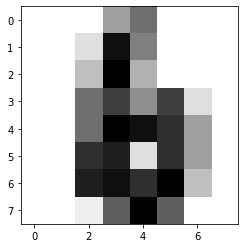

In [13]:
point = data[1561][0]

plot_digit(point)
print(f'Prediction: {knn(22, point, data)}')

<center><h2>Section 3 - Model Testing and Accuracy</h2></center>

### 3.1 - Create Training Data and Testing Data

The problem with the test above, is that the model has already 'seen' the test data. This is because there is no separation of the data used to train the model and the data used to test it. In fact, the first element returned in the ```distances``` list will be ```0```, since the distance calculated will be between the test point and itself.

One way to solve this issue is to present a percentage of the data to the model for training, whilst holding back the remaining images for testing. This creates a set of *training data* and *testing data*.

Below the function accepts an input for the percentage for the data to be used for testing (given as a value from 0 to 1). This then returns two lists, containing the training and testing data respectively. A function exists for this in ```sklearn.model_selection.train_test_split```, but has been written here from scratch.

In [14]:
def train_test(test_split, data):
    test_size = int(len(data)*test_split)
    train_data, test_data = data[test_size:], data[:test_size]
    return train_data, test_data

Here the dataset has been split into 80% training data, and 20% testing data. By using a test-train split, we can assess the accuracy of the model by looking at its performance against the testing data. Deciding on the percentage split can affect the performance of the model. Using too small too few training samples will give poorer accuracy, but using too many will decrease the confidence in the results, since the amount of testing is reduced. Much research has been done on this topic, and further discussion can be found in [4].

In [15]:
# Split the data
train_data, test_data = train_test(0.20, data)

# Print the number of data points in each set
print(f'Images in training set: {len(train_data)}')
print(f'Images in testing set: {len(test_data)}')

# Check the sum of the two sets adds to the total in the dataset
print(f'Total images: {len(train_data)+len(test_data)}')

Images in training set: 1438
Images in testing set: 359
Total images: 1797


### 3.2 - Determine the Accuracy of the Model

It is useful to know how well the model performs in order to make judgements about the user-defined parameters such as the value of *k*, and the test-train split ratio. Because of this, a function is defined below that takes in a value for *k*, percentage of testing data, and the data to test as arguments, then returns the accuracy for the model over the testing data. This can then be called upon for multiple different combinations of input parameters to produce the highest model accuracy.

In [16]:
def accuracy(k, test_split, data):

    train_data, test_data = train_test(test_split, data)

    success_count = 0
    for point in test_data:
        if knn(k, point[0], train_data) == point[1]:
            success_count += 1

    accuracy = (success_count/len(test_data)) * 100
    return accuracy

In [17]:
k = 10
test_split = 0.2
print(f'Accuracy for k = {k}, with {test_split*100}% testing data: {accuracy(k, test_split, data):.2f}%')

Accuracy for k = 10, with 20.0% testing data: 94.43%


<center><h2>Section 4 - Tuning the Hyperparameters</h2></center>

### 4.1 - Use Different Combinations of Hyperparameters

One way to find the optimum user-defined parameters (collectively called hyperparameters), is to use a range of combinations and measure the accuracies. In this case, the hyperparameters are *k* and the test-train split ratio, so different combinations of these values parameters can be used to determine the optimum configuration for the model.The next step is to plot the accuracy for each combination, to try to identify any trends. This will help tune model for future classifications.

Some heuristics exist for determining a value for *k* (such as taking the square root of the size of the dataset), but it is common practice to initialise *k* as a random value. In the previous section, *k* was given the value ```10``` without much regard for the accuracy this would have on the results. Now the algorithm has been tested, its parameters can be tuned.

In [49]:
results = []

for k in range(1,6):
    for test_split in [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]:
        a = accuracy(k, test_split, data)
        results.append([a, k, test_split])

results.sort(key=lambda x: x[0], reverse=True)
tuned = results[0]
print(f'The optimum parameters are k = {tuned[1]} with {tuned[2]}% testing data')
print(f'The highest accuracy was {tuned[0]:.2f}%')

The optimum parameters are k = 1 with 0.25% testing data
The highest accuracy was 96.66%


### 4.2 - Plot the Accuracy Curves

Once the results have been collected, plots can be made to visualise the effect of *k* and the test-train split ratio on the accuracy of the model over the testing data. The trends in these plots can be used to indentify which hyperparameters values will give the best accuracy, without testing every possible combination of values.

Below a function is defined that will extract results from the optimisation study above. This is used to create each of the lines in the plots.

In [98]:
def get_results(k=None, split=None):

    if k != None and split == None:
        output = [result for result in results if result[1] == k]
        output.sort(key=lambda x: x[2])
        output = [result[0] for result in output]
    
    elif split != None and k == None:
        output = [result for result in results if result[2] == split]
        output.sort(key=lambda x: x[1])
        output = [result[0] for result in output]

    return output

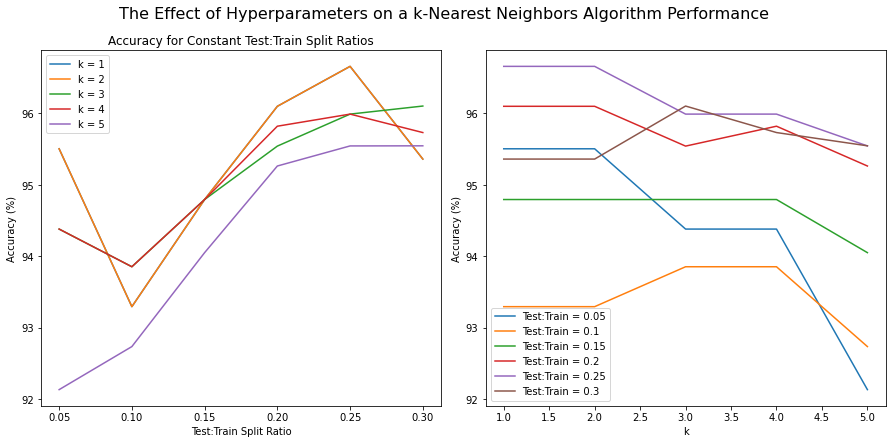

In [102]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(12.5)
fig.set_figheight(6.25)
fig.suptitle('The Effect of Hyperparameters on a k-Nearest Neighbors Algorithm Performance ', fontsize=16)

for i in range(1,6):
    ax[0].plot([0.05, 0.10, 0.15, 0.20, 0.25, 0.30], get_results(k=i), label=f'k = {i}')

for i in [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]:
    ax[1].plot([1,2,3,4,5], get_results(split=i), label=f'Test:Train = {i}')

ax[0].set_title('Accuracy for Constant k Values')
ax[0].set_xlabel('Test:Train Split Ratio')
ax[0].set_ylabel('Accuracy (%)')
ax[0].legend()

ax[0].set_title('Accuracy for Constant Test:Train Split Ratios')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend()

fig.tight_layout()


### 4.3 - Comments on Results

This algorithm showed best performance with a *k* value of 1. Typically, such small values of *k* are undesirable since they can lead to unstable decision boundaries [5]. Larger values of *k* smooth out decision boundary, making the algorithm more robust to anomylous values. For the training set used, the accuracies for *k* = 1 and *k* = 2 are identical. Since these both produce the highest accuracy, but *k* = 2 has a slightly more stable decision boundary, this value should be taken forward to use with future unknown data points.

The algorithm also showed a non-linear relationship between the test:train split ratio and the accuracy, with accuracy dipping then seeming to peak around 96.7% for a 25:75 split of test:train. This result was more expected, since lower percentages of test data (such as 25%) leave a greater amount of data available to train the algorithm and hence increase its accuracy. The decrease in accuracy with a 10% and 15% split was less expected, and may be attributed to the algorithm 'learning the noise' of the input data set, which would then be detrimental to classifying the testing data

### 4.4 - Conclusion

For the k-Nearest Neighbors algorithm used in this notebook, and for the dataset tested on, the best combination of hyperparameters appears to be:

* *k* = 2
* Test:Train split = 25:75

<center><h2>Section 5 - Using Custom Images</h2></center>

<center><h2>Section 6 - References</h2></center>

[1] Dataset background and downloads - [Lecun](http://yann.lecun.com/exdb/mnist/)

[2] Machine learning in Python - [Sci-Kit Learn](https://scikit-learn.org/stable/)

[3] Overview of the kNN algorithm - [Towards Data Science](https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761)

[4] Test-train split ratios - [Baeldung](https://www.baeldung.com/cs/train-test-datasets-ratio#:~:text=If%20we%20search%20the%20Internet,even%20a%2050%3A50%20split.)

[5] Choosing a value of k - [Towards Data Science](https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb)